
--- Iniciando Geração de Gráficos de Insights Adicionais (sem 3D) ---
Base de dados para visualização carregada: 5293 linhas.
Coluna alvo 'faixa_salarial_agrupada_3cat_v7' criada para visualização.
Contagem das faixas salariais em df_main_viz:
faixa_salarial_agrupada_3cat_v7
Salário Médio    1663
Salário Baixo    1631
Salário Alto     1459
Name: count, dtype: int64


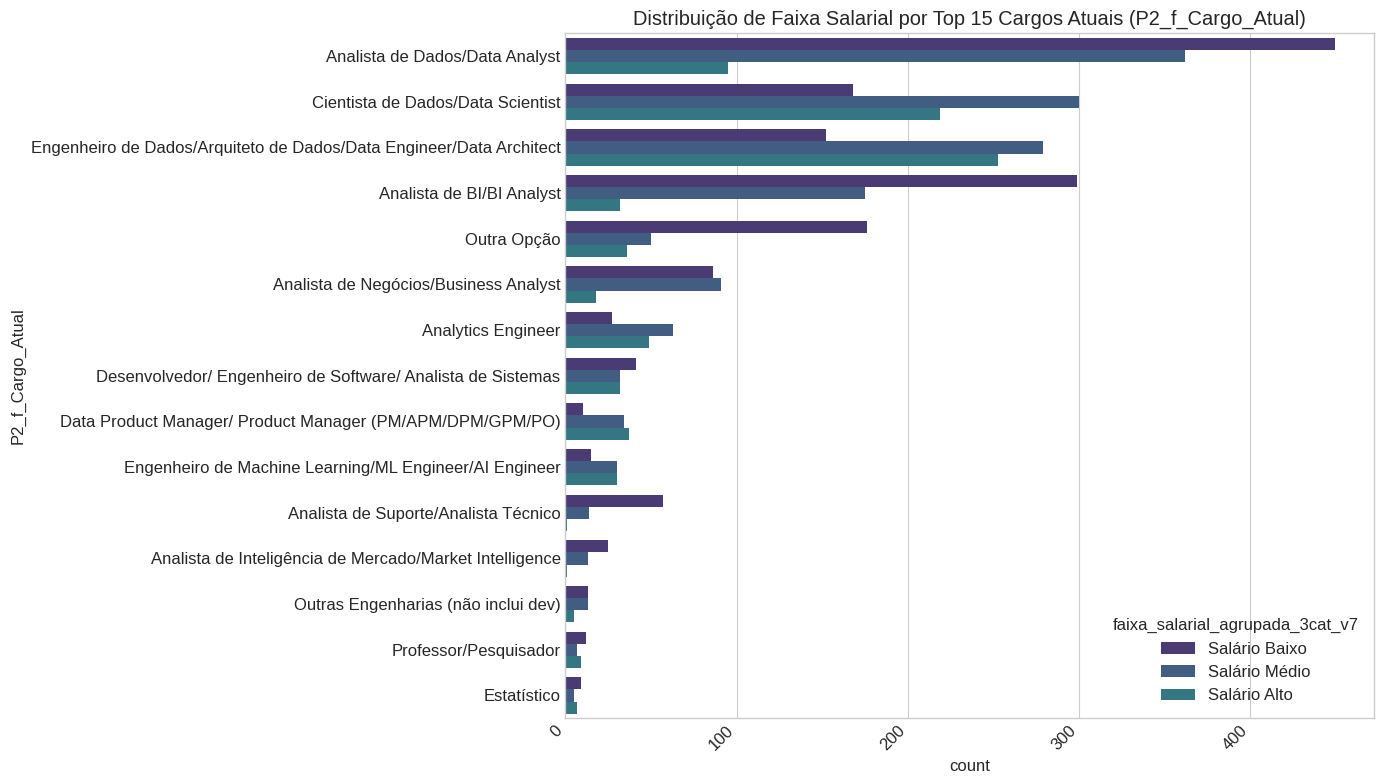

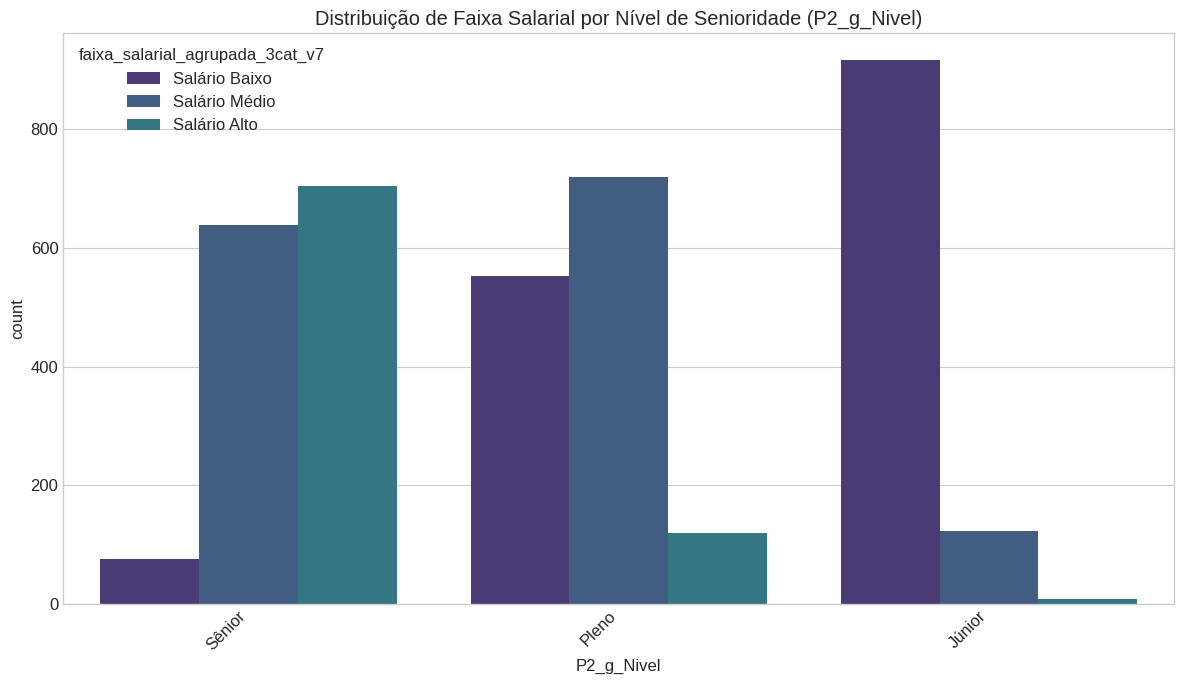

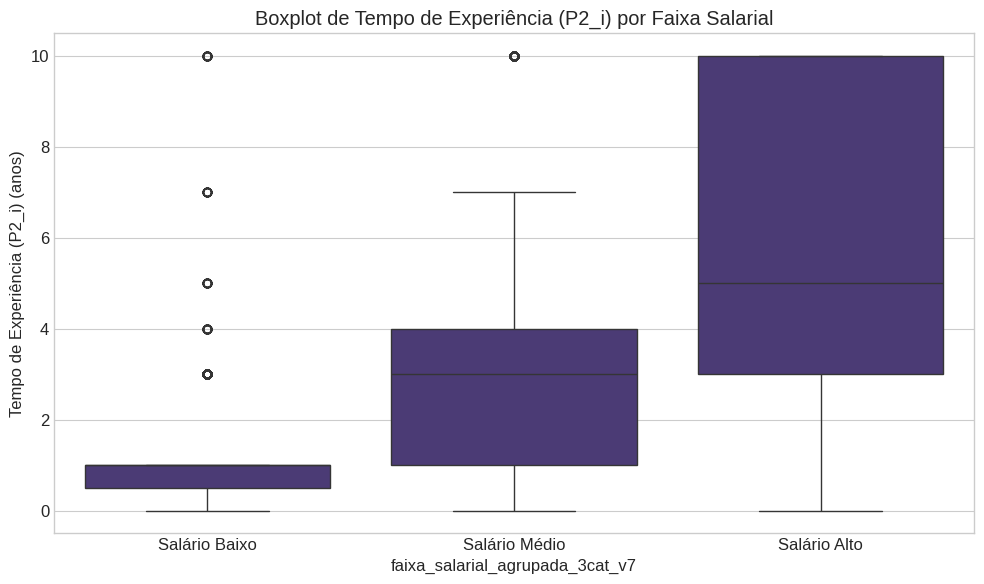

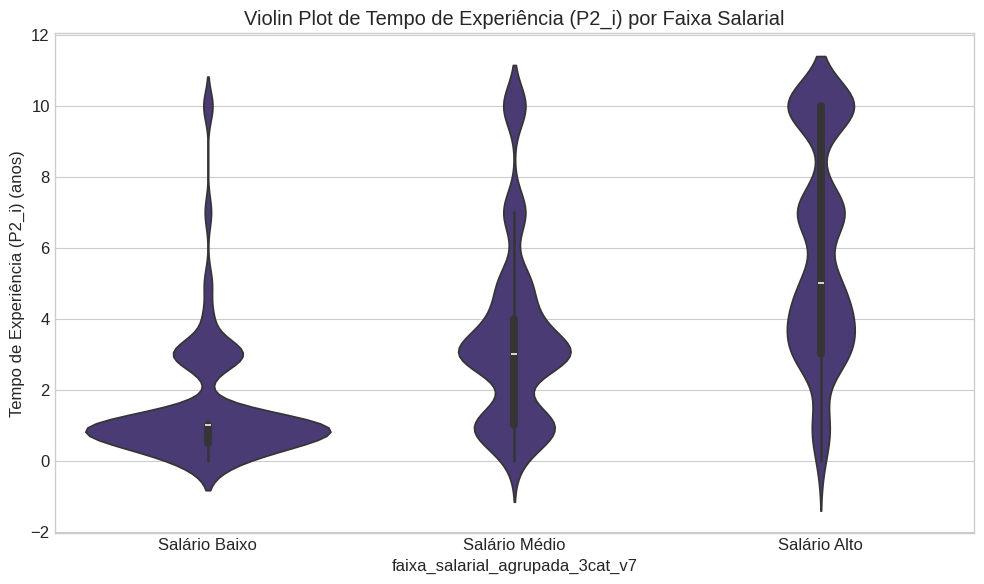


Seções de gráficos 3D foram removidas do script.

--- Geração de Gráficos de Insights Adicionais Concluída (sem 3D) ---
Gráficos 2D (se gerados) salvos em: /content/visualizacoes_classificacao_salario_v7_rfecv


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import re # Certifique-se de que re está importado se clean_col_name precisar
# from mpl_toolkits.mplot3d import Axes3D # Removido pois não será mais usado para gráficos 3D

# --- Funções de pré-processamento ---
# Se estas funções já estiverem definidas no seu notebook, você pode comentar/remover esta seção.
# É crucial que sejam as mesmas usadas no treinamento do modelo.

def clean_col_name(col_name):
    """Limpa o nome da coluna para ser compatível com LightGBM."""
    original_input = col_name
    if isinstance(col_name, tuple):
        col_name = "_".join(str(item).strip() for item in col_name)
    elif not isinstance(col_name, str):
        col_name = str(col_name)
    col_name = re.sub(r'[^\w\s-]', '', col_name).strip()
    col_name = re.sub(r'[-\s]+', '_', col_name)
    col_name = re.sub(r"_+", "_", col_name)
    col_name = col_name.strip("_")
    if not col_name: return f"col_limpa_vazia_{hash(original_input)}"
    if col_name and col_name[0].isdigit(): col_name = "_" + col_name
    return col_name

def extract_salary_lower_bound(salary_range_str):
    """Extrai o limite inferior numérico de uma string de faixa salarial."""
    if pd.isna(salary_range_str): return np.nan
    s = str(salary_range_str).lower().replace('r$', '').replace('.', '').replace('/mês', '').strip()
    match_de_a = re.search(r'de\s*(\d+)\s*a\s*(\d+)', s)
    if match_de_a: return float(match_de_a.group(1))
    match_acima_de = re.search(r'acima de\s*(\d+)', s)
    if match_acima_de: return float(match_acima_de.group(1))
    match_menos_de = re.search(r'menos de\s*(\d+)', s)
    if match_menos_de: return 0
    match_so_numeros = re.findall(r'\d+', s)
    if match_so_numeros: return float(match_so_numeros[0])
    return np.nan

def clean_experience_to_numeric(exp_val):
    """Converte strings de experiência para valores numéricos."""
    if pd.isna(exp_val):
        return np.nan
    s = str(exp_val).lower().strip()
    if 'menos de 1 ano' in s or 'menos de um ano' in s or '< 1 ano' in s:
        return 0.5
    if 'não tenho experiência' in s or 'sem experiência' in s:
        return 0
    numbers = re.findall(r'\d+\.?\d*', s)
    if numbers:
        return float(numbers[0])
    return np.nan

# --- Fim das Funções de pré-processamento ---

print("\n--- Iniciando Geração de Gráficos de Insights Adicionais (sem 3D) ---")

output_dir = 'visualizacoes_classificacao_salario_v7_rfecv'
os.makedirs(output_dir, exist_ok=True)

file_path = "Main_database (2).xlsx"
if not os.path.exists(file_path):
    print(f"ERRO: Arquivo de dados '{file_path}' não encontrado. Ajuste o caminho.")
else:
    df_main_viz = pd.read_excel(file_path)
    original_columns_viz = df_main_viz.columns.tolist()
    df_main_viz.columns = [clean_col_name(col) for col in original_columns_viz]
    print(f"Base de dados para visualização carregada: {df_main_viz.shape[0]} linhas.")

    col_mapping_viz = {
        "target_original_salary_range": "P2_h",
        "tempo_experiencia_P2i": "P2_i",
        "nivel_senioridade_P2g": "P2_g_Nivel",
        "cargo_atual_P2f": "P2_f_Cargo_Atual"
    }
    target_col_processed_name = "faixa_salarial_agrupada_3cat_v7"

    original_salary_col_name_viz = col_mapping_viz["target_original_salary_range"]

    if original_salary_col_name_viz not in df_main_viz.columns:
        print(f"ERRO: Coluna original de salário '{original_salary_col_name_viz}' não encontrada no DataFrame após limpeza de nomes.")
    else:
        df_main_viz.dropna(subset=[original_salary_col_name_viz], inplace=True)
        df_main_viz['salary_numeric_lower_bound'] = df_main_viz[original_salary_col_name_viz].apply(extract_salary_lower_bound)
        df_main_viz.dropna(subset=['salary_numeric_lower_bound'], inplace=True)

        num_salary_groups = 3
        salary_group_labels_3cat = ["Salário Baixo", "Salário Médio", "Salário Alto"]
        try:
            df_main_viz[target_col_processed_name] = pd.qcut(df_main_viz['salary_numeric_lower_bound'], num_salary_groups, labels=salary_group_labels_3cat, duplicates='drop')
        except ValueError:
            print("pd.qcut falhou, tentando pd.cut como fallback para target_col_processed_name...")
            quantiles = np.linspace(0, 1, num_salary_groups + 1)
            bins_values = df_main_viz['salary_numeric_lower_bound'].quantile(quantiles).to_list()
            bins_values[0] = min(bins_values[0], df_main_viz['salary_numeric_lower_bound'].min() - 0.01) # Ensure the smallest value is included
            bins_values[-1] = max(bins_values[-1], df_main_viz['salary_numeric_lower_bound'].max() + 0.01) # Ensure the largest value is included
            bins_values = sorted(list(set(bins_values)))

            if len(bins_values) >= 2:
                num_actual_bins = len(bins_values) -1
                current_labels = salary_group_labels_3cat[:num_actual_bins] if num_actual_bins <= len(salary_group_labels_3cat) else [f"Cat_{j+1}" for j in range(num_actual_bins)]
                if len(current_labels) == num_actual_bins:
                        df_main_viz[target_col_processed_name] = pd.cut(df_main_viz['salary_numeric_lower_bound'], bins=bins_values, labels=current_labels, include_lowest=True, duplicates='drop')
                else:
                        print("Fallback pd.cut: labels insuficientes ou incompatíveis com os bins gerados.")
            else:
                print("Fallback pd.cut: bins insuficientes.")

        if target_col_processed_name in df_main_viz.columns:
            df_main_viz.dropna(subset=[target_col_processed_name], inplace=True)
            print(f"Coluna alvo '{target_col_processed_name}' criada para visualização.")
            print(f"Contagem das faixas salariais em df_main_viz:\n{df_main_viz[target_col_processed_name].value_counts()}")
        else:
            print(f"ERRO: Coluna alvo '{target_col_processed_name}' não pôde ser criada.")


    exp_col_name_viz = col_mapping_viz["tempo_experiencia_P2i"]
    if exp_col_name_viz in df_main_viz.columns:
        df_main_viz[exp_col_name_viz] = df_main_viz[exp_col_name_viz].apply(clean_experience_to_numeric)
        # Correção do FutureWarning:
        df_main_viz[exp_col_name_viz] = df_main_viz[exp_col_name_viz].fillna(df_main_viz[exp_col_name_viz].median())
    else:
        print(f"Aviso: Coluna de experiência '{exp_col_name_viz}' não encontrada para visualização.")

    feature_cargo = col_mapping_viz["cargo_atual_P2f"]
    feature_exp = col_mapping_viz["tempo_experiencia_P2i"]
    feature_nivel = col_mapping_viz["nivel_senioridade_P2g"]

    features_to_plot = [feature_cargo, feature_exp, feature_nivel]
    missing_plot_features = [f for f in features_to_plot if f not in df_main_viz.columns and f is not None] # Check for None too
    if missing_plot_features:
        print(f"AVISO: Features de plotagem ausentes em df_main_viz: {missing_plot_features}")

    # --- Gráficos 2D ---
    if target_col_processed_name in df_main_viz.columns: # Proceed only if target exists
        if feature_cargo in df_main_viz.columns:
            plt.figure(figsize=(14, 8))
            top_n_cargos = df_main_viz[feature_cargo].value_counts().nlargest(15).index
            sns.countplot(y=feature_cargo, hue=target_col_processed_name, data=df_main_viz[df_main_viz[feature_cargo].isin(top_n_cargos)], order=top_n_cargos)
            plt.title(f'Distribuição de Faixa Salarial por Top 15 Cargos Atuais ({feature_cargo})')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'insight_cargo_vs_faixa_salarial.png'))
            plt.show()
            plt.close()

        if feature_nivel in df_main_viz.columns:
            plt.figure(figsize=(12, 7))
            sns.countplot(x=feature_nivel, hue=target_col_processed_name, data=df_main_viz, order=df_main_viz[feature_nivel].value_counts().index)
            plt.title(f'Distribuição de Faixa Salarial por Nível de Senioridade ({feature_nivel})')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'insight_nivel_vs_faixa_salarial.png'))
            plt.show()
            plt.close()

        if feature_exp in df_main_viz.columns:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=target_col_processed_name, y=feature_exp, data=df_main_viz)
            plt.title(f'Boxplot de Tempo de Experiência ({feature_exp}) por Faixa Salarial')
            plt.ylabel(f'Tempo de Experiência ({feature_exp}) (anos)')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'insight_experiencia_vs_faixa_salarial_boxplot.png'))
            plt.show()
            plt.close()

            plt.figure(figsize=(10, 6))
            sns.violinplot(x=target_col_processed_name, y=feature_exp, data=df_main_viz)
            plt.title(f'Violin Plot de Tempo de Experiência ({feature_exp}) por Faixa Salarial')
            plt.ylabel(f'Tempo de Experiência ({feature_exp}) (anos)')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'insight_experiencia_vs_faixa_salarial_violin.png'))
            plt.show()
            plt.close()


        print("\nSeções de gráficos 3D foram removidas do script.")

    else:
        print(f"AVISO: Coluna alvo '{target_col_processed_name}' não foi criada, pulando gráficos.")

    print("\n--- Geração de Gráficos de Insights Adicionais Concluída (sem 3D) ---")
    print(f"Gráficos 2D (se gerados) salvos em: {os.path.abspath(output_dir)}")